## Импорт библиотек

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

## Загрузка данных

In [ ]:
!unzip cats_data.zip

Archive:  cats_data.zip
replace cats_data/cats/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
DATA_DIR = './cats/'

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_data = ImageFolder(DATA_DIR, transform=transforms.Compose([
                                                         transforms.Resize(image_size),
                                                         transforms.CenterCrop(image_size),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(*stats)
                                                         ]))

In [ ]:
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Визуализация**

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


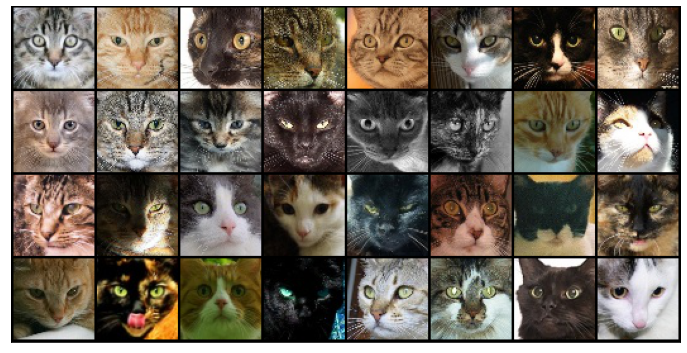

In [ ]:
show_batch(train_loader)

## DCGAN


### Генератор

In [ ]:
latent_size = 128

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=128):
        super(Generator, self).__init__()

        self.image_shape = (3,64,64)
       
        self.model = nn.Sequential(
                          # in: latent_size x 1 x 1
                          nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
                          nn.BatchNorm2d(512),
                          nn.ReLU(True),
                          # out: 512 x 4 x 4'

                          nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(256),
                          nn.ReLU(True),
                          # out: 256 x 8 x 8

                          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(128),
                          nn.ReLU(True),
                          # out: 128 x 16 x 16

                          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.BatchNorm2d(64),
                          nn.ReLU(True),
                          # out: 64 x 32 x 32

                          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
                          nn.Tanh()
                          # out: 3 x 64 x 64
                    )

    def forward(self, z):
        img = self.model(z)
        return img

### Дискриминатор

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.image_shape = (3,64,64)
        self.model = nn.Sequential(
                            # in: 3 x 64 x 64
                            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(64),
                            nn.LeakyReLU(0.2, inplace=True),
                            # out: 64 x 32 x 32

                            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(128),
                            nn.LeakyReLU(0.2, inplace=True),
                            # out: 128 x 16 x 16

                            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(256),
                            nn.LeakyReLU(0.2, inplace=True),
                            # out: 256 x 8 x 8

                            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(512),
                            nn.LeakyReLU(0.2, inplace=True),
                            # out: 512 x 4 x 4

                            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
                            # out: 1 x 1 x 1

                            nn.Flatten(),
                            nn.Sigmoid()
                    )

    def forward(self, img):
        output = self.model(img)
        return output

## Обучение

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
epochs = 15
lr = 0.0002
batch_size = 64
loss = nn.BCELoss()

In [ ]:
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=

In [ ]:
def generate_images(fakes,image_folder):
    #Function to generate image grid and save
    image_grid = make_grid(fakes.to(device),padding=2,nrow=4,normalize=True)
    if not os.path.exists(image_folder):
        os.makedirs(image_folder)
    save_image(image_grid,'{}/img_{}.png'.format(image_folder,epoch))

In [ ]:
losses_g = []
losses_d = []


for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Обучаем дискриминатор
        # Real inputs - реальные картинки из MNIST
        # Fake inputs - выход генератора
        # Real inputs должны быть классифицированы как 1, fake - 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Обучаем генератор
        # Цель генератора - заставить дискриминатор верить, что все картинки класса 1
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        # Пытаемся обмануть дискриминатор
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Сохраняем лосс обоих подмоделей
        losses_g.append(G_loss)
        losses_d.append(D_loss)


        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

        # Сохраняем сгенерированные изображения
        with torch.no_grad():
          fakes = G(fixed_noise)
          image_folder = './generated_images'
          generate_images(fakes,image_folder)

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 Iteration 100: discriminator_loss 0.042 generator_loss 5.283
Epoch 0 Iteration 124: discriminator_loss 0.060 generator_loss 6.159
Epoch 1 Iteration 100: discriminator_loss 0.077 generator_loss 3.523
Epoch 1 Iteration 124: discriminator_loss 0.396 generator_loss 14.796
Epoch 2 Iteration 100: discriminator_loss 0.091 generator_loss 6.002
Epoch 2 Iteration 124: discriminator_loss 0.128 generator_loss 8.892
Epoch 3 Iteration 100: discriminator_loss 0.292 generator_loss 8.255
Epoch 3 Iteration 124: discriminator_loss 0.415 generator_loss 11.646
Epoch 4 Iteration 100: discriminator_loss 0.326 generator_loss 4.956
Epoch 4 Iteration 124: discriminator_loss 0.082 generator_loss 6.810
Epoch 5 Iteration 100: discriminator_loss 0.211 generator_loss 4.948
Epoch 5 Iteration 124: discriminator_loss 0.950 generator_loss 18.973
Epoch 6 Iteration 100: discriminator_loss 0.219 generator_loss 4.665
Epoch 6 Iteration 124: discriminator_loss 0.441 generator_loss 15.622
Epoch 7 Iteration 100: discrim

In [ ]:
from IPython.display import Image

In [ ]:
!ls ./generated_images

img_0.png   img_12.png	img_1.png  img_4.png  img_7.png
img_10.png  img_13.png	img_2.png  img_5.png  img_8.png
img_11.png  img_14.png	img_3.png  img_6.png  img_9.png


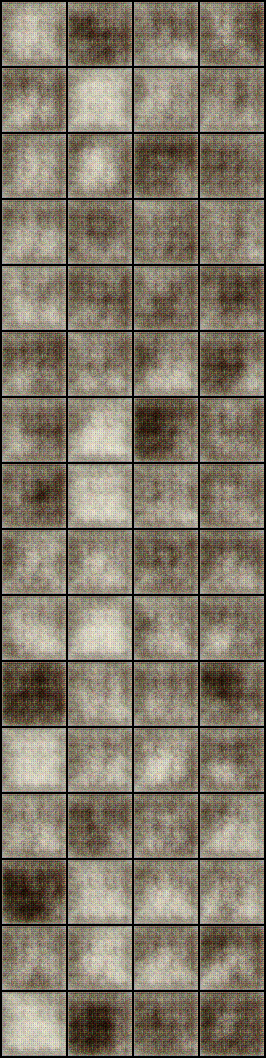

In [ ]:
Image('./generated_images/img_0.png')

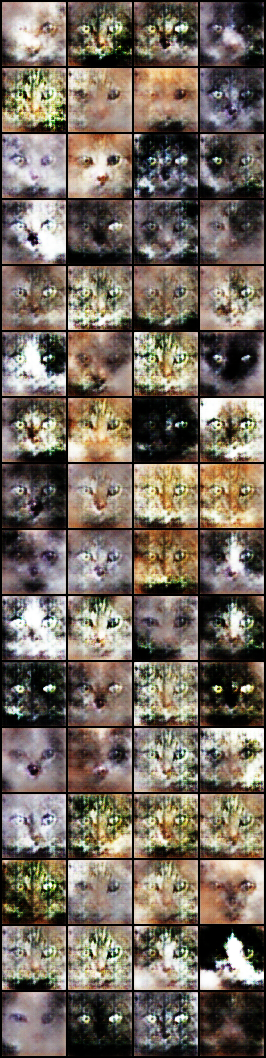

In [ ]:
Image('./generated_images/img_9.png')

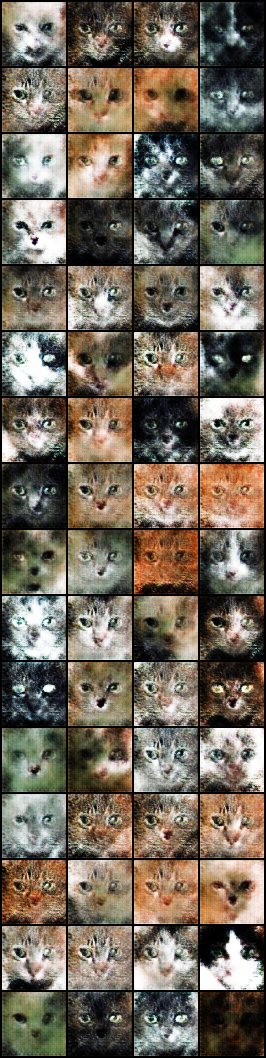

In [ ]:
Image('./generated_images/img_14.png')

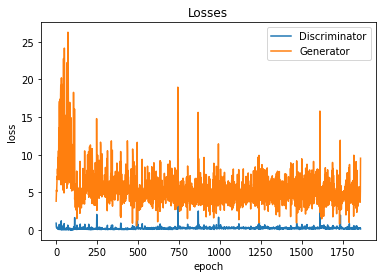

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');